In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
#Vamos a crear una matriz con los datos de 'global_ghf.csv' y eliminamos la primera columna 'ID' que no es util para nada
datos = np.delete(np.genfromtxt('global_ghf.csv', delimiter=',', skip_header=1), 0, axis=1)
# Vamos a eliminar las filas en las cuales GHF tenga un valor mayor a 140, ya que son datos muy alejados de los demas
filas_a_eliminar = datos[:, 13] > 140 
# Eliminar las filas que cumplen la condición
datos = datos[~filas_a_eliminar]

In [3]:
print("Tamaño de los datos:", np.shape(datos))

Tamaño de los datos: (4028, 20)


# 1. Particion del data set

In [4]:
# Ahora vamos a particionar la matriz de forma aleatoria como no lo pidieron
num_80 = int(datos.shape[0] * 0.8)  # es un numero que me indica cual es el 80% de las filas

In [5]:
indices_aleatorios = np.random.permutation(datos.shape[0])#me genera un array con las permutaciones de los indices de las filas
indices_grupo1 = indices_aleatorios[:num_80] # Coge el 80% del array anterior
indices_grupo2 = indices_aleatorios[num_80:] # coge el 20% restante del array
# de esta forma cada fila de la matriz original se asigna a uno de los dos grupos de manera única

In [6]:
datos_entrenamiento = datos[indices_grupo1]
datos_validacion = datos[indices_grupo2]

In [7]:
print("Tamaño de los datos de entrenamiento:", np.shape(datos_entrenamiento))
print("Tamaño de los datos de validacion:", np.shape(datos_validacion))

Tamaño de los datos de entrenamiento: (3222, 20)
Tamaño de los datos de validacion: (806, 20)


# 2. Modelo lineal basado en SVD

In [8]:
# Ahora cogemos la matriz de entrenamiento y los valores de entrenamiento y los de validacion para uso posterior
matriz_entrenamiento = np.delete(datos_entrenamiento, 13, axis=1)
matriz_validacion = np.delete(datos_validacion, 13, axis=1)
GHF_entrenamiento = datos_entrenamiento[:,13]
GHF_validacion = datos_validacion[:,13]

In [9]:
print("Tamaño de la matriz de entrenamiento:", np.shape(matriz_entrenamiento))
print("Tamaño GHF de entrenamiento:", np.shape(GHF_entrenamiento))
print("Tamaño matriz de validacion:", np.shape(matriz_validacion))
print("Tamañao GHF de validacion:", np.shape(GHF_validacion))

Tamaño de la matriz de entrenamiento: (3222, 19)
Tamaño GHF de entrenamiento: (3222,)
Tamaño matriz de validacion: (806, 19)
Tamañao GHF de validacion: (806,)


In [10]:
# Encontramos los vectores y valores singulares usando una funcion de numpy
U, s, VT = np.linalg.svd(matriz_entrenamiento, full_matrices=False)

In [11]:
print("Tamaño VT.T:" , np.shape(VT.T))
print("Tamaño Sigma_inverso:" , np.shape(np.linalg.inv(np.diag(s))))
print("Tamaño U.T:" , np.shape(U.T))
print("Tamaño de GHF valores medidios:", np.shape(GHF_entrenamiento))

Tamaño VT.T: (19, 19)
Tamaño Sigma_inverso: (19, 19)
Tamaño U.T: (19, 3222)
Tamaño de GHF valores medidios: (3222,)


In [12]:
w = VT.T @ np.linalg.inv(np.diag(s)) @ U.T @ GHF_entrenamiento
print("Tamaño de la funcion de peso:",np.shape(w))

Tamaño de la funcion de peso: (19,)


In [13]:
# con este vector de pesos podemos construir una funcion de prediccion
def GHF_prediccion(x):
    GHFP = x @ w
    return GHFP

# 3. Grafica de los valores singulares

Text(0, 0.5, 'Valor singular')

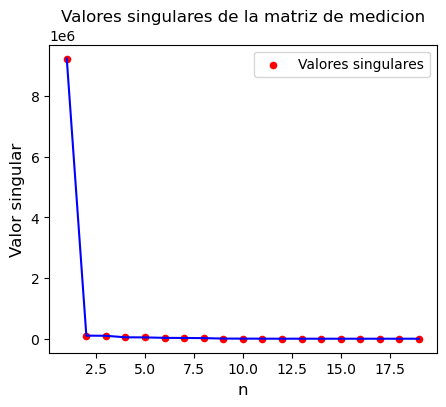

In [14]:
# creaos un arange para que se la variable independiente n
n = np.arange(1, 20)
#creamos un plot
a = plt.figure(figsize=(5,4))
az = a.add_subplot(111)
# ploteamos un escater y una recta
az.plot(n, s, color='blue')
az.scatter(n, s, s=20, color='red', label='Valores singulares')

plt.legend()
plt.title('Valores singulares de la matriz de medicion')
plt.xlabel('n', fontsize=12)
plt.ylabel('Valor singular', fontsize=12)

Este resultado es congruente, ya que los primeros valores singulares de la matriz son lo que tienen mayor relevancia, entre mas cerca esten los valores singulares a cero menos relevancia tienen, por lo tanto puede ser posible que con menos variables se puede lograr una prediccion igualmente buena

# 4, 5, 6. Grafica de las predicciones los residuales y el RMSE

A partir de aca genere unas funcianes con las cuales grafique los GHF predichos en contra de los GHF medidos, tambien genere la grafica de los residuales y los coloque en subplots, para cada grafica calcule el error cuadratico medio

In [15]:
# construimos una funcion para calcular el error cuadratico medio normalizado
def calcular_rmse(y_true, y_pred):
    # Calcular la diferencia entre las etiquetas verdaderas y las predicciones
    diferencias = y_true - y_pred
    # Elevar al cuadrado las diferencias
    diferencias_cuadradas = diferencias ** 2
    # Calcular la media de las diferencias cuadradas
    mse = np.mean(diferencias_cuadradas)
    #finalmente calculamos el error cuadratico medio normalizado
    media = np.mean(y_true)
    rmse = np.sqrt(mse)/media
    return rmse

In [16]:
# Contruimos una funcion que calcula regresiones lineales
def realizar_regresion_lineal(x, y):

    # Asegurarse de que x sea un array bidimensional
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    # Crear y entrenar el modelo de regresión lineal
    modelo = LinearRegression()
    modelo.fit(x, y)
    
    # Obtener la pendiente y la intercepción
    pendiente = modelo.coef_[0]
    intercepcion = modelo.intercept_
    
    return modelo, pendiente, intercepcion

In [17]:
# Construimos una funcion graficadora, el primer parametro 'title' debe ser texto y correponde al titulo del plot, el argumeto
# 'medicion' corresponde a los datos GHF medidos ya sea para el cojunto de validacion o entrenamiento,igualente el argumento 
# 'prediccion' corresponde a la funcion GHF de prediccion, sea congruente con el conjunto que se use en ambos argumentos
def graficadora(title,medicion,prediccion):
    # tamaños del plt
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # calculo del error cuadratico medio normalizado para la prediccion y la mediccion
    RMSE = round(calcular_rmse(medicion, prediccion), 2)

    # modelo de regresion lineal para los GHF
    modelo, pendiente, intercepcion = realizar_regresion_lineal(medicion, prediccion)
    predicciones_y = modelo.predict(np.array(medicion).reshape(-1, 1))

    # los residuales son
    r = prediccion - medicion

    # modelo de regresion lineal para los residuales
    modelo_r, pendiente_r, intercepcion_r = realizar_regresion_lineal(prediccion, r)
    predicciones_yr = modelo_r.predict(np.array(prediccion).reshape(-1, 1))

    # calculo del error cuadratico medio normalizado para los residuales
    RMSE_r = round(calcular_rmse(prediccion, r), 2)


    #graficamos el primer plot que es la grafica de la prediccion en contra de los datos medidos
    ax[0].set_ylim(0,145)
    ax[0].set_xlim(0,145)

    # plot del sacatter
    ax[0].scatter(medicion, prediccion, c="green", s= 10, label='Prediccion por SVD')
    # plot de la regresion lineal
    ax[0].plot(medicion, predicciones_y, color='red', label='Regresión Lineal')

    ax[0].legend()
    ax[0].set_title('RMSE de la prediccion=' + str(RMSE))
    ax[0].set_xlabel('GHF medido ($mW/m^2$)', fontsize=12)
    ax[0].set_ylabel('GHF prediccion ($mW/m^2$)', fontsize=12)

    # graficamos elsegundo plot con los residuales
    ax[1].scatter(prediccion, r, s=10, color='blue', label='Residuales VS prediccion')
    # regresion lineal de los residuales
    ax[1].plot(prediccion, predicciones_yr, color='red', label='Regresión Lineal')

    ax[1].legend()
    ax[1].set_title('RMSE de los residuales=' + str(RMSE_r))
    ax[1].set_xlabel('GHF prediccion ($mW/m^2$)', fontsize=12)
    ax[1].set_ylabel('Residuales ($mW/m^2$)', fontsize=12)

    plt.suptitle(title, fontsize=15)
    # Mostrar el gráfico
    plt.show()

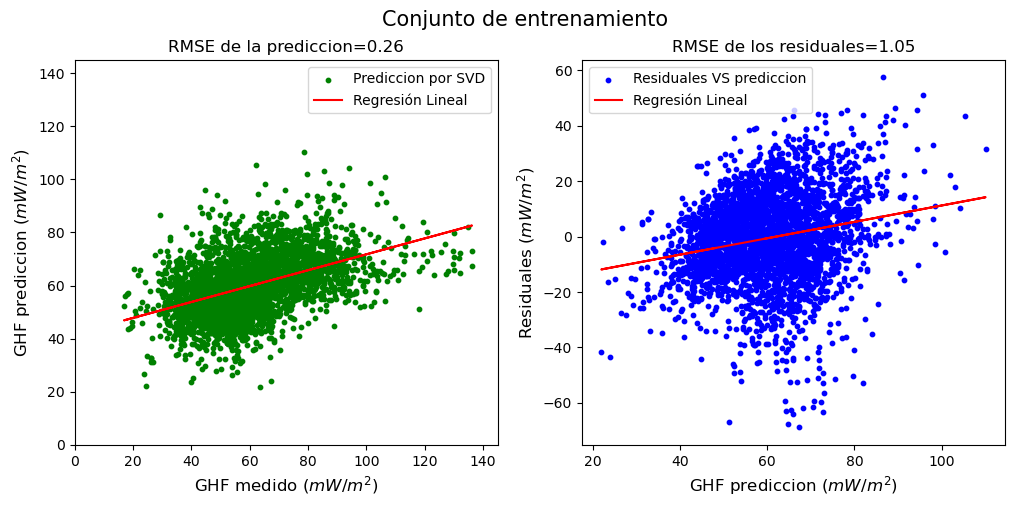

In [18]:
# Grafica para el conjunto de datos de entrenamiento
graficadora('Conjunto de entrenamiento',GHF_entrenamiento,GHF_prediccion(matriz_entrenamiento))

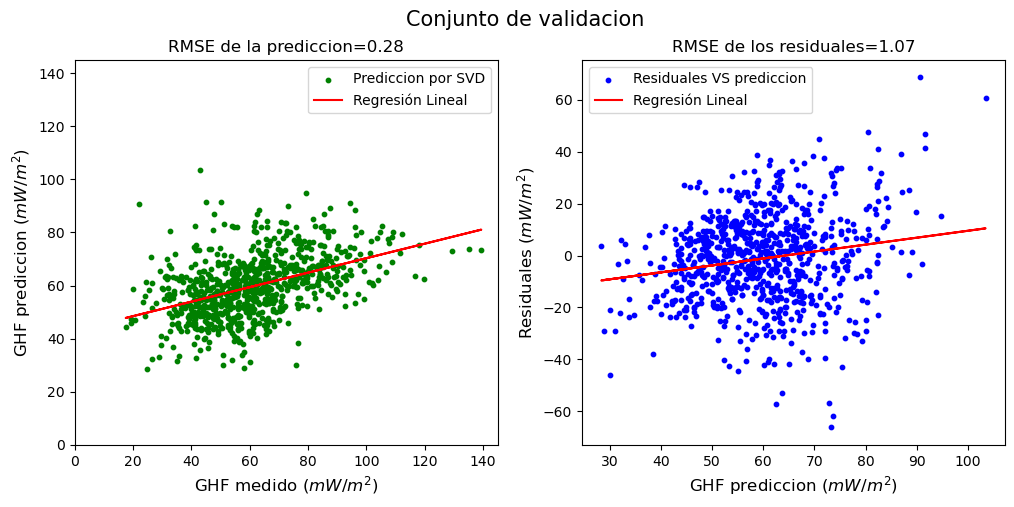

In [19]:
# Grafica del conjunto de datos de validacion
graficadora('Conjunto de validacion',GHF_validacion,GHF_prediccion(matriz_validacion))